In [19]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
from PIL import Image
import os
import itertools
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
root_dir = "data"

In [3]:
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

In [7]:
# Iterate over class folders in the data directory
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Class: {class_name}")
        # Walk through all subdirectories
        for subdir, _, files in os.walk(class_path):
            resolution_count = {}
            total_images = 0
            for file in files:
                if file.lower().endswith(image_extensions):
                    try:
                        img_path = os.path.join(subdir, file)
                        with Image.open(img_path) as img:
                            resolution = img.size  # (width, height)
                            resolution_count[resolution] = resolution_count.get(resolution, 0) + 1
                            total_images += 1
                    except Exception as e:
                        print(f"Error opening {file}: {e}")
            if total_images > 0:
                subfolder_name = os.path.relpath(subdir, class_path)
                print(f"  Subfolder: {subfolder_name}")
                for res, count in resolution_count.items():
                    print(f"    Resolution: {res}, Count: {count}")

Class: apple2orange
  Subfolder: apple2orange\testA
    Resolution: (256, 256), Count: 266
  Subfolder: apple2orange\testB
    Resolution: (256, 256), Count: 248
  Subfolder: apple2orange\trainA
    Resolution: (256, 256), Count: 995
  Subfolder: apple2orange\trainB
    Resolution: (256, 256), Count: 1019
Class: cezanne2photo
  Subfolder: cezanne2photo\testA
    Resolution: (256, 256), Count: 58
  Subfolder: cezanne2photo\testB
    Resolution: (256, 256), Count: 751
  Subfolder: cezanne2photo\trainA
    Resolution: (256, 256), Count: 525
  Subfolder: cezanne2photo\trainB
    Resolution: (256, 256), Count: 6287
Class: cityscapes
  Subfolder: cityscapes\evaluate_cityscape
    Resolution: (512, 256), Count: 500
  Subfolder: cityscapes\test
    Resolution: (512, 256), Count: 500
  Subfolder: cityscapes\testA
    Resolution: (256, 256), Count: 500
  Subfolder: cityscapes\testB
    Resolution: (256, 256), Count: 500
  Subfolder: cityscapes\train
    Resolution: (512, 256), Count: 2975
  Subf

Triedy ktoré nemajú konzistentné rozlíšenie:cityscapes,iphone2dslr_flower,maps,

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparametre

In [41]:
IMG_SIZE = 64
BATCH_SIZE = 1
LR = 0.0002
EPOCHS = 20
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0

In [42]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train', max_samples=None):
        self.transform = transform
        self.root = root
        self.mode = mode
        self.files_A = sorted(os.listdir(os.path.join(root, f"{mode}A")))
        self.files_B = sorted(os.listdir(os.path.join(root, f"{mode}B")))
        if max_samples:
            self.files_A = self.files_A[:max_samples]
            self.files_B = self.files_B[:max_samples]
        self.path_A = os.path.join(root, f"{mode}A")
        self.path_B = os.path.join(root, f"{mode}B")

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.path_A, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.path_B, self.files_B[index % len(self.files_B)])).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [43]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Generator

In [44]:
# models.py
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residuals=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):  # 64 → 32 → 16
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_residuals):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):  # 16 → 32 → 64
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, kernel_size=7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


### Discriminator

In [45]:
# models.py (continued)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),  # (64x64) -> (32x32)
            *discriminator_block(64, 128),  # -> (16x16)
            *discriminator_block(128, 256),  # -> (8x8)
            *discriminator_block(256, 512),  # -> (4x4)
            nn.Conv2d(512, 1, kernel_size=4, padding=1)  # Output patch size (3x3 or so)
        )

    def forward(self, x):
        return self.model(x)


### Loss functions

In [46]:
adversarial_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()
identity_criterion = nn.L1Loss()

In [47]:
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), 
    lr=LR, betas=(0.5, 0.999)
)
d_A_optimizer = optim.Adam(D_A.parameters(), lr=LR, betas=(0.5, 0.999))
d_B_optimizer = optim.Adam(D_B.parameters(), lr=LR, betas=(0.5, 0.999))

### Training loop

In [48]:
def train(dataloader):
    for epoch in range(EPOCHS):
        for i, batch in enumerate(dataloader):
            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)

            # -----------------------------------
            #  Train Generators G_AB and G_BA
            # -----------------------------------
            g_optimizer.zero_grad()

            # Identity loss
            same_B = G_AB(real_B)
            loss_identity_B = identity_criterion(same_B, real_B) * LAMBDA_IDENTITY

            same_A = G_BA(real_A)
            loss_identity_A = identity_criterion(same_A, real_A) * LAMBDA_IDENTITY

            # GAN loss
            fake_B = G_AB(real_A)
            pred_fake_B = D_B(fake_B)
            loss_GAN_AB = adversarial_criterion(pred_fake_B, torch.ones_like(pred_fake_B))

            fake_A = G_BA(real_B)
            pred_fake_A = D_A(fake_A)
            loss_GAN_BA = adversarial_criterion(pred_fake_A, torch.ones_like(pred_fake_A))

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = cycle_criterion(recov_A, real_A)

            recov_B = G_AB(fake_A)
            loss_cycle_B = cycle_criterion(recov_B, real_B)

            # Total generator loss
            g_loss = (loss_GAN_AB + loss_GAN_BA) + \
                     LAMBDA_CYCLE * (loss_cycle_A + loss_cycle_B) + \
                     (loss_identity_A + loss_identity_B)

            g_loss.backward()
            g_optimizer.step()

            # -----------------------------------
            #  Train Discriminator A
            # -----------------------------------
            d_A_optimizer.zero_grad()

            pred_real = D_A(real_A)
            loss_D_real = adversarial_criterion(pred_real, torch.ones_like(pred_real))

            pred_fake = D_A(fake_A.detach())
            loss_D_fake = adversarial_criterion(pred_fake, torch.zeros_like(pred_fake))

            d_A_loss = (loss_D_real + loss_D_fake) * 0.5
            d_A_loss.backward()
            d_A_optimizer.step()

            # -----------------------------------
            #  Train Discriminator B
            # -----------------------------------
            d_B_optimizer.zero_grad()

            pred_real = D_B(real_B)
            loss_D_real = adversarial_criterion(pred_real, torch.ones_like(pred_real))

            pred_fake = D_B(fake_B.detach())
            loss_D_fake = adversarial_criterion(pred_fake, torch.zeros_like(pred_fake))

            d_B_loss = (loss_D_real + loss_D_fake) * 0.5
            d_B_loss.backward()
            d_B_optimizer.step()

            # Logging
            if i % 100 == 0:
                print(
                    f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                    f"[D_A Loss: {d_A_loss.item():.4f}] [D_B Loss: {d_B_loss.item():.4f}] "
                    f"[G Loss: {g_loss.item():.4f}]"
                )


In [50]:
path_to_dataset="data/apple2orange/apple2orange"

dataset = ImageDataset(path_to_dataset, transform=transform,max_samples=50)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
train(dataloader)

[Epoch 0/20] [Batch 0/50] [D_A Loss: 0.3983] [D_B Loss: 0.5925] [G Loss: 20.4950]
[Epoch 1/20] [Batch 0/50] [D_A Loss: 0.4403] [D_B Loss: 0.4732] [G Loss: 11.5591]
[Epoch 2/20] [Batch 0/50] [D_A Loss: 0.2197] [D_B Loss: 0.2660] [G Loss: 10.1817]
[Epoch 3/20] [Batch 0/50] [D_A Loss: 0.3625] [D_B Loss: 0.1647] [G Loss: 9.2065]
[Epoch 4/20] [Batch 0/50] [D_A Loss: 0.0867] [D_B Loss: 0.1212] [G Loss: 8.9458]
[Epoch 5/20] [Batch 0/50] [D_A Loss: 0.2474] [D_B Loss: 0.1697] [G Loss: 12.3365]
[Epoch 6/20] [Batch 0/50] [D_A Loss: 0.1836] [D_B Loss: 0.1956] [G Loss: 11.0183]
[Epoch 7/20] [Batch 0/50] [D_A Loss: 0.1887] [D_B Loss: 0.0558] [G Loss: 7.5304]
[Epoch 8/20] [Batch 0/50] [D_A Loss: 0.1316] [D_B Loss: 0.3778] [G Loss: 9.3204]
[Epoch 9/20] [Batch 0/50] [D_A Loss: 0.1145] [D_B Loss: 0.4432] [G Loss: 7.6147]
[Epoch 10/20] [Batch 0/50] [D_A Loss: 0.2681] [D_B Loss: 0.2512] [G Loss: 8.0389]
[Epoch 11/20] [Batch 0/50] [D_A Loss: 0.1004] [D_B Loss: 0.2622] [G Loss: 7.6271]
[Epoch 12/20] [Batch 

In [57]:
test_dataset = ImageDataset(path_to_dataset, transform=transform, mode='test', max_samples=5)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [58]:
def show_images(real, fake, title="Input vs Output"):
    real = real * 0.5 + 0.5
    fake = fake * 0.5 + 0.5

    images = torch.cat([real, fake], dim=3)
    grid = make_grid(images, nrow=1)

    np_img = grid.permute(1, 2, 0).detach().cpu().numpy()
    plt.figure(figsize=(6, 3))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title)
    plt.show()


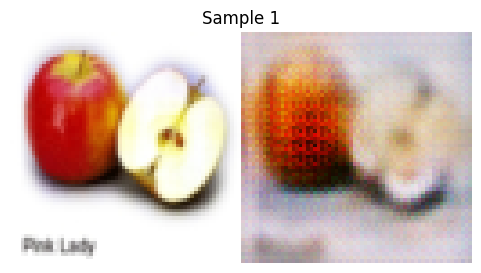

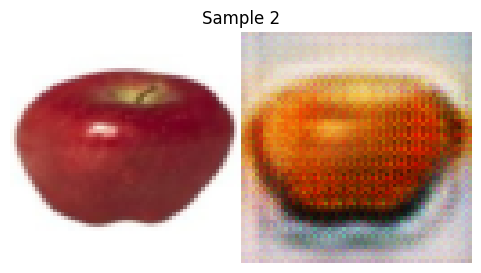

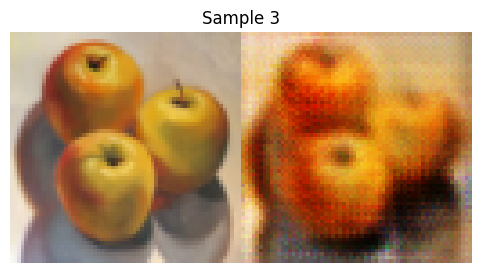

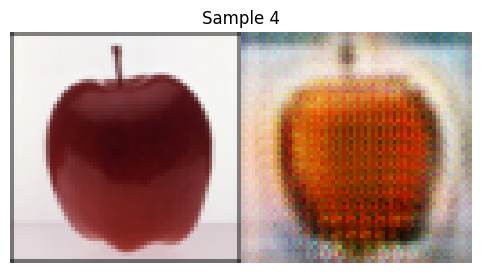

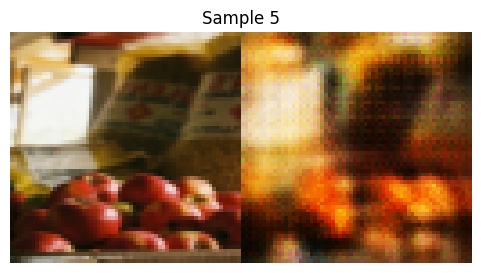

In [59]:
G_AB.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        real_A = batch["A"].to(device)
        fake_B = G_AB(real_A)
        show_images(real_A, fake_B, title=f"Sample {i+1}")
